# Continuous Optimization Fundamentals

This notebook covers continuous optimization using gradient-based methods with JAX and Optax. You'll learn:

- **Basic optimization** with different optimizers (LBFGS, Adam, SGD, RMSprop)
- **Progress tracking** with integrated progress bars
- **Convergence monitoring** and tolerance settings
- **Parameter bounds** using box constraints
- **Result visualization** and optimization trajectories

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-grid-search/blob/main/examples/03-basic-optimization.ipynb)

## Setup and Imports

In [23]:
# Install the package if running in Colab
try:
    import google.colab
    !pip install jax_grid_search ipywidgets
except ImportError:
    pass  # Not in Colab

import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from jax_grid_search import optimize, ProgressBar
import time

## 1. Understanding Continuous Optimization

Unlike grid search which evaluates discrete parameter combinations, continuous optimization uses gradients to find optimal parameter values in continuous space.

### Key Differences:
- **Grid Search**: Evaluates predefined discrete points
- **Continuous Optimization**: Uses gradients to navigate parameter space efficiently
- **Convergence**: Stops when gradient updates become small enough
- **Efficiency**: Can find precise optima with fewer evaluations

## 2. Simple Quadratic Optimization

Let's start with a simple quadratic function that has a known global minimum.

In [24]:
def simple_quadratic(x):
    """
    Simple quadratic function: f(x) = (x - 3)²
    Global minimum at x = 3 with value = 0
    """
    return jnp.sum((x - 3.0) ** 2)

# Test the function and its gradient
test_x = jnp.array([0.0])
print(f"Function value at x=0: {simple_quadratic(test_x)}")
print(f"True minimum at x=3: {simple_quadratic(jnp.array([3.0]))}")

# JAX can automatically compute gradients
grad_fn = jax.grad(simple_quadratic)
print(f"Gradient at x=0: {grad_fn(test_x)}")
print(f"Gradient at x=3: {grad_fn(jnp.array([3.0]))}")

Function value at x=0: 9.0
True minimum at x=3: 0.0
Gradient at x=0: [-6.]
Gradient at x=3: [0.]


### Optimize with LBFGS

In [25]:
# Initial parameters (starting point)
init_params = jnp.array([0.0])

# Create LBFGS optimizer
optimizer = optax.lbfgs()

print("Optimizing simple quadratic with LBFGS...")

# Run optimization with progress tracking
with ProgressBar() as progress:
    best_params, final_state = optimize(
        init_params=init_params,
        objective_fn=simple_quadratic,
        opt=optimizer,
        max_iter=50,
        tol=1e-8,
        progress=progress
    )

print(f"\nOptimization Results:")
print(f"  Starting point: {init_params}")
print(f"  Optimal parameters: {best_params}")
print(f"  Final objective value: {simple_quadratic(best_params)}")
print(f"  True minimum: 3.0")
print(f"  Error: {abs(best_params[0] - 3.0):.2e}")

Output()

Optimizing simple quadratic with LBFGS...



Optimization Results:
  Starting point: [0.]
  Optimal parameters: [3.]
  Final objective value: 0.0
  True minimum: 3.0
  Error: 0.00e+00


## 3. Comparing Different Optimizers

Different optimizers have different strengths. Let's compare several on the same problem.

In [26]:
def rosenbrock_2d(params):
    """
    The famous Rosenbrock function: f(x,y) = 100(y - x²)² + (1 - x)²
    Global minimum at (1, 1) with value = 0
    This is a classic test function for optimization algorithms.
    """
    x, y = params[0], params[1]
    return 100.0 * (y - x**2)**2 + (1.0 - x)**2

# Test the function
print(f"Rosenbrock at (0, 0): {rosenbrock_2d(jnp.array([0.0, 0.0]))}")
print(f"Rosenbrock at (1, 1): {rosenbrock_2d(jnp.array([1.0, 1.0]))}")

# Define different optimizers to compare
optimizers = {
    "LBFGS": optax.lbfgs(),
    "Adam": optax.adam(learning_rate=0.01),
}

# Starting point (challenging for optimization)
init_params = jnp.array([-1.5, 2.0])

print(f"\nStarting optimization from: {init_params}")
print(f"Initial objective value: {rosenbrock_2d(init_params):.4f}")
print(f"Target: (1, 1) with value 0\n")

# Store results for comparison
results = {}

for id, (name, optimizer) in enumerate(optimizers.items()):
    print(f"Testing {name}...")
    
    start_time = time.time()
    with ProgressBar() as progress:
        best_params, final_state = optimize(
            init_params=init_params,
            objective_fn=rosenbrock_2d,
            opt=optimizer,
            max_iter=1000,
            tol=1e-6,
            progress=progress,
            progress_id=id
        )
    end_time = time.time()
    
    final_value = rosenbrock_2d(best_params)
    distance_to_optimum = jnp.linalg.norm(best_params - jnp.array([1.0, 1.0]))
    
    results[name] = {
        'params': best_params,
        'value': final_value,
        'distance': distance_to_optimum,
        'time': end_time - start_time
    }
    
    print(f"  Final params: [{best_params[0]:.4f}, {best_params[1]:.4f}]")
    print(f"  Final value: {final_value:.6f}")
    print(f"  Distance to optimum: {distance_to_optimum:.4f}")
    print(f"  Time: {end_time - start_time:.2f}s\n")

Output()

Rosenbrock at (0, 0): 1.0
Rosenbrock at (1, 1): 0.0

Starting optimization from: [-1.5  2. ]
Initial objective value: 12.5000
Target: (1, 1) with value 0

Testing LBFGS...


Output()

  Final params: [1.0000, 1.0000]
  Final value: 0.000000
  Distance to optimum: 0.0000
  Time: 0.76s

Testing Adam...


  Final params: [0.0674, 0.0040]
  Final value: 0.869859
  Distance to optimum: 1.3645
  Time: 0.89s



### Visualizing Optimizer Comparison

In [27]:
# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

optimizer_names = list(results.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(optimizer_names)))

# 1. Final objective values (log scale)
values = [results[name]['value'] for name in optimizer_names]
bars1 = ax1.bar(optimizer_names, values, color=colors, alpha=0.7)
ax1.set_ylabel('Final Objective Value')
ax1.set_title('Final Objective Values (lower is better)')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars1, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{value:.2e}', ha='center', va='bottom', rotation=90)

# 2. Distance to true optimum
distances = [results[name]['distance'] for name in optimizer_names]
bars2 = ax2.bar(optimizer_names, distances, color=colors, alpha=0.7)
ax2.set_ylabel('Distance to True Optimum')
ax2.set_title('Accuracy (lower is better)')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Computation time
times = [results[name]['time'] for name in optimizer_names]
bars3 = ax3.bar(optimizer_names, times, color=colors, alpha=0.7)
ax3.set_ylabel('Computation Time (seconds)')
ax3.set_title('Speed (lower is better)')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Parameter convergence visualization
true_optimum = jnp.array([1.0, 1.0])
ax4.plot(true_optimum[0], true_optimum[1], 'r*', markersize=20, 
         label='True Optimum (1,1)', zorder=5)

for i, name in enumerate(optimizer_names):
    params = results[name]['params']
    ax4.plot(params[0], params[1], 'o', color=colors[i], markersize=10, 
             label=f'{name}: ({params[0]:.3f}, {params[1]:.3f})', alpha=0.8)

ax4.set_xlabel('Parameter 1 (x)')
ax4.set_ylabel('Parameter 2 (y)')
ax4.set_title('Final Parameter Values')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-0.5, 2.0)
ax4.set_ylim(-0.5, 2.5)

plt.tight_layout()
plt.show()

# Print summary
print("\n=== OPTIMIZER COMPARISON SUMMARY ===")
best_value = min(results[name]['value'] for name in optimizer_names)
best_accuracy = min(results[name]['distance'] for name in optimizer_names)
fastest = min(results[name]['time'] for name in optimizer_names)

for name in optimizer_names:
    r = results[name]
    print(f"{name:>8}: Value={r['value']:.2e}, Distance={r['distance']:.3f}, Time={r['time']:.2f}s")
    
print(f"\nBest performers:")
for name in optimizer_names:
    r = results[name]
    if r['value'] == best_value:
        print(f"  Lowest objective: {name}")
    if r['distance'] == best_accuracy:
        print(f"  Most accurate: {name}")
    if r['time'] == fastest:
        print(f"  Fastest: {name}")

/tmp/ipykernel_176210/2788984134.py:56: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



=== OPTIMIZER COMPARISON SUMMARY ===
   LBFGS: Value=0.00e+00, Distance=0.000, Time=0.76s
    Adam: Value=8.70e-01, Distance=1.365, Time=0.89s

Best performers:
  Lowest objective: LBFGS
  Most accurate: LBFGS
  Fastest: LBFGS


## 4. Parameter Bounds and Constraints

Often you need to constrain parameters to valid ranges. The library supports box constraints.

In [28]:
def constrained_objective(params):
    """
    Objective function that benefits from constraints.
    Without constraints, optimizer might explore unrealistic parameter regions.
    """
    x, y = params[0], params[1]
    
    # This function has its minimum outside the constraint region
    # Minimum is at (-1, -1), but we'll constrain to [0, 2] x [0, 2]
    return (x + 1.0)**2 + (y + 1.0)**2 + 0.1*jnp.sin(5*x)*jnp.cos(5*y)

# Test unconstrained vs constrained optimization
init_params = jnp.array([1.5, 1.5])
optimizer = optax.adam(learning_rate=0.1)

print("Comparing constrained vs unconstrained optimization:\n")

# Unconstrained optimization
print("1. UNCONSTRAINED optimization:")
with ProgressBar() as progress:
    unconstrained_params, unconstrained_state = optimize(
        init_params=init_params,
        objective_fn=constrained_objective,
        opt=optimizer,
        max_iter=200,
        tol=1e-6,
        progress=progress,
        progress_id=0
    )

unconstrained_value = constrained_objective(unconstrained_params)
print(f"  Final params: [{unconstrained_params[0]:.4f}, {unconstrained_params[1]:.4f}]")
print(f"  Final value: {unconstrained_value:.6f}")

# Constrained optimization
print("\n2. CONSTRAINED optimization [0,2] x [0,2]:")
lower_bounds = jnp.array([0.0, 0.0])
upper_bounds = jnp.array([2.0, 2.0])

with ProgressBar() as progress:
    constrained_params, constrained_state = optimize(
        init_params=init_params,
        objective_fn=constrained_objective,
        opt=optimizer,
        max_iter=200,
        tol=1e-6,
        progress=progress,
        progress_id=1,
        lower_bound=lower_bounds,
        upper_bound=upper_bounds
    )

constrained_value = constrained_objective(constrained_params)
print(f"  Final params: [{constrained_params[0]:.4f}, {constrained_params[1]:.4f}]")
print(f"  Final value: {constrained_value:.6f}")

# Check bounds satisfaction
in_bounds = jnp.all(constrained_params >= lower_bounds) and jnp.all(constrained_params <= upper_bounds)
print(f"  Bounds satisfied: {in_bounds}")

print(f"\n3. COMPARISON:")
print(f"  Unconstrained finds better objective value: {unconstrained_value < constrained_value}")
print(f"  But constrained solution respects parameter bounds")

# True global minimum (outside bounds)
true_minimum = jnp.array([-1.0, -1.0])
true_minimum_value = constrained_objective(true_minimum)
print(f"\nTrue global minimum at {true_minimum}: {true_minimum_value:.6f}")
print(f"But this is outside our constraint region [0,2] x [0,2]")

Output()

Comparing constrained vs unconstrained optimization:

1. UNCONSTRAINED optimization:


Output()

  Final params: [-0.9749, -0.8075]
  Final value: -0.023976

2. CONSTRAINED optimization [0,2] x [0,2]:


  Final params: [0.0000, 0.0000]
  Final value: 2.000000
  Bounds satisfied: True

3. COMPARISON:
  Unconstrained finds better objective value: True
  But constrained solution respects parameter bounds

True global minimum at [-1. -1.]: 0.027201
But this is outside our constraint region [0,2] x [0,2]


### Visualizing Constrained Optimization

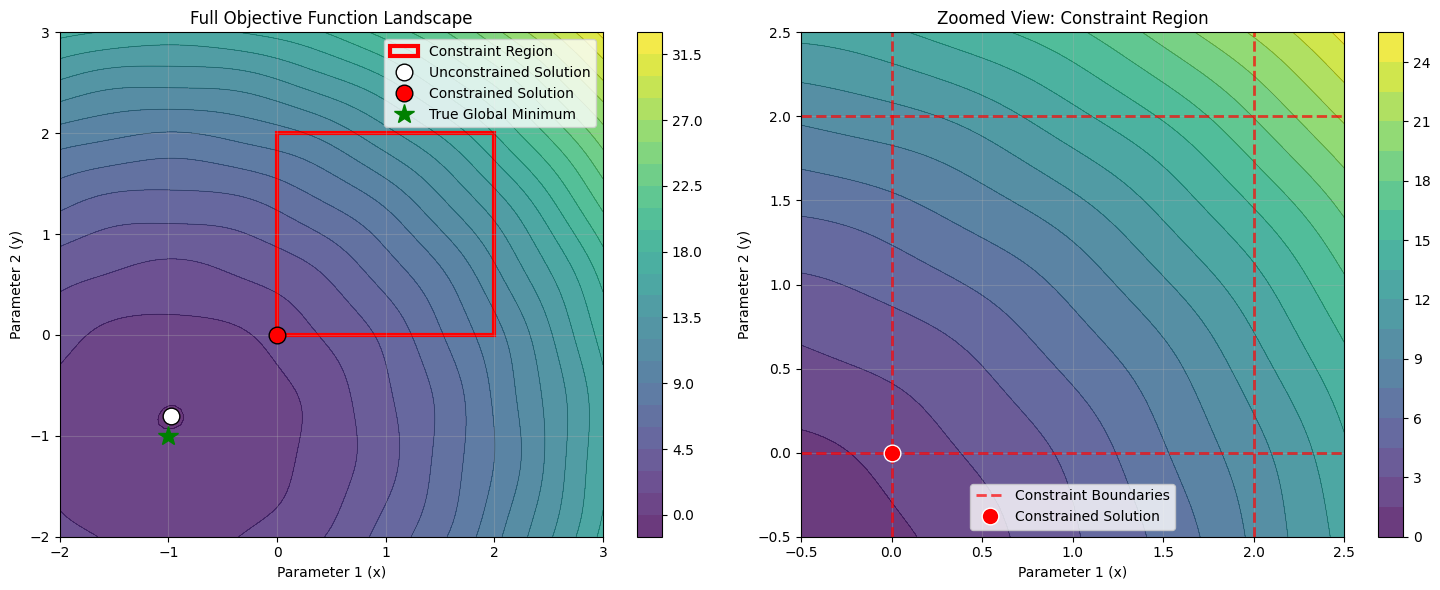

In [29]:
# Create a visualization of the constraint region and solutions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create a grid for contour plot
x_range = jnp.linspace(-2, 3, 100)
y_range = jnp.linspace(-2, 3, 100)
X, Y = jnp.meshgrid(x_range, y_range)

# Evaluate function over the grid
Z = jnp.zeros_like(X)
for i in range(len(x_range)):
    for j in range(len(y_range)):
        Z = Z.at[j, i].set(constrained_objective(jnp.array([X[j, i], Y[j, i]])))

# Plot 1: Full landscape
contour1 = ax1.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax1.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)

# Mark constraint region
constraint_box = plt.Rectangle((0, 0), 2, 2, fill=False, edgecolor='red', 
                              linewidth=3, label='Constraint Region')
ax1.add_patch(constraint_box)

# Mark solutions
ax1.plot(unconstrained_params[0], unconstrained_params[1], 'wo', 
         markersize=12, markeredgecolor='black', linewidth=2, 
         label='Unconstrained Solution')
ax1.plot(constrained_params[0], constrained_params[1], 'ro', 
         markersize=12, markeredgecolor='black', linewidth=2,
         label='Constrained Solution')
ax1.plot(-1, -1, 'g*', markersize=15, label='True Global Minimum')

ax1.set_xlabel('Parameter 1 (x)')
ax1.set_ylabel('Parameter 2 (y)')
ax1.set_title('Full Objective Function Landscape')
ax1.legend()
ax1.grid(True, alpha=0.3)
fig.colorbar(contour1, ax=ax1)

# Plot 2: Zoomed view of constraint region
x_zoom = jnp.linspace(-0.5, 2.5, 50)
y_zoom = jnp.linspace(-0.5, 2.5, 50)
X_zoom, Y_zoom = jnp.meshgrid(x_zoom, y_zoom)

Z_zoom = jnp.zeros_like(X_zoom)
for i in range(len(x_zoom)):
    for j in range(len(y_zoom)):
        Z_zoom = Z_zoom.at[j, i].set(constrained_objective(jnp.array([X_zoom[j, i], Y_zoom[j, i]])))

contour2 = ax2.contourf(X_zoom, Y_zoom, Z_zoom, levels=20, cmap='viridis', alpha=0.8)
ax2.contour(X_zoom, Y_zoom, Z_zoom, levels=20, colors='black', alpha=0.3, linewidths=0.5)

# Highlight constraint boundaries
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Constraint Boundaries')
ax2.axvline(x=2, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(y=2, color='red', linestyle='--', linewidth=2, alpha=0.7)

# Mark constrained solution
ax2.plot(constrained_params[0], constrained_params[1], 'ro', 
         markersize=12, markeredgecolor='white', linewidth=2,
         label='Constrained Solution')

ax2.set_xlabel('Parameter 1 (x)')
ax2.set_ylabel('Parameter 2 (y)')
ax2.set_title('Zoomed View: Constraint Region')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.5, 2.5)
ax2.set_ylim(-0.5, 2.5)
fig.colorbar(contour2, ax=ax2)

plt.tight_layout()
plt.show()